# Compare WAA methods with the openMRG dataset
In this notebook three methods to compensate for wet antenna attenuation compared. As CML dataset the opnMRG dataset is used [(Andersson et al. 2022)](https://doi.org/10.5194/essd-14-5411-2022).
The three WAA methods are from following publications and named after the first author:
* [Schleiss et al. 2013](https://doi.org/10.1109/LGRS.2012.2236074)
* [Leijnse et al. 2008](http://www.sciencedirect.com/science/article/pii/S0309170808000535)
* [Pastorek et al. 2021](https://doi.org/10.1109/TGRS.2021.3110004) (the model denoted "KR-alt" in this study is used here)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import opensense_data_downloader_and_transformer as oddt
import pandas as pd
import pycomlink as pycml
import xarray as xr
from tqdm import tqdm

0.3.0


In [2]:
# function from OpenSense sandbox https://github.com/OpenSenseAction/OPENSENSE_sandbox/blob/main/notebooks/Explore_existing_datasets.ipynb
oddt.download_andersson_2022_OpenMRG(
    local_path="data/andersson_2022_OpenMRG/", print_output=True
)

File already exists at desired location data/andersson_2022_OpenMRG/OpenMRG.zip
Not downloading!


In [3]:
# function from sandbox
ds_cml = oddt.transform_andersson_2022_OpenMRG(
    fn="data/andersson_2022_OpenMRG/OpenMRG.zip",
    path_to_extract_to="data/andersson_2022_OpenMRG/",
    time_start_end=(
        None,
        None,
    ),  # default (None, None) -> no timeslicing. ie. ('2015-08-31T00', None),
    restructure_data=True,
)

/bg/home/graf-m/notebooks/cml_method_comparison/waa_comparison/opensense_data_downloader_and_transformer.py:303: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'sublink' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  ds_multindex = ds.assign_coords({'sublink':df_metadata.index})


### merge city and smhi gauges with 60 min aggregation for wet-dry classification 

In [4]:
df_gauges_city = pd.read_csv(
    "data/andersson_2022_OpenMRG/gauges/city/CityGauges-2015JJA.csv",
    index_col=0,
    parse_dates=True,
)

df_gauges_city_metadata = pd.read_csv(
    "/pd/home/graf-m/notebooks/cml_method_comparison/gauges/city/CityGauges-metadata.csv",
    index_col=0,
)

In [5]:
ds_gauges_city_org = xr.Dataset(
    data_vars=dict(
        rainfall_amount=(["station_id", "time"], df_gauges_city.T),
    ),
    coords=dict(
        station_id=df_gauges_city_metadata.index.values,
        time=df_gauges_city.index.values,
        lon=(["station_id"], df_gauges_city_metadata.Longitude_DecDeg),
        lat=(["station_id"], df_gauges_city_metadata.Latitude_DecDeg),
        location=(["station_id"], df_gauges_city_metadata.Location),
        type=(["station_id"], df_gauges_city_metadata.Type),
        quantization=(["station_id"], df_gauges_city_metadata["Resolution (mm)"]),
    ),
)
# gauge data for evaluation
ds_gauges_city_1h = ds_gauges_city_org.resample(time="60min").sum()

In [6]:
df_gauge_smhi = pd.read_csv(
    "/pd/home/graf-m/notebooks/cml_method_comparison/gauges/smhi/GbgA-71420-2015JJA.csv",
    index_col=0,
    parse_dates=True,
)


ds_gauges_smhi = xr.Dataset(
    data_vars=dict(
        rainfall_amount=(["station_id", "time"], [df_gauge_smhi.Pvol_mm.values]),
    ),
    coords=dict(
        station_id=["SMHI"],
        time=df_gauge_smhi.index.values,
        lon=(["station_id"], [11.9924]),
        lat=(["station_id"], [57.7156]),
        location=(["station_id"], ["Goeteburg A"]),
        type=(["station_id"], ["15 min rainfall sum"]),
        quantization=(["station_id"], [0.1]),
    ),
)
ds_gauges_smhi_1h = ds_gauges_smhi.resample(time="60min").sum()

In [7]:
ds_gauges_ref_1h = xr.concat([ds_gauges_city_1h, ds_gauges_smhi_1h], dim="station_id")

#### Get 5 min radar reference as wet dry classifier

In [8]:
ds_radar_along = xr.open_dataset("data/andersson_2022_OpenMRG/radar/radar_along_cml.nc")

#### calculate distance between city rain gauges and CML center points

In [9]:
ds_cml["lon_center"] = (ds_cml.site_0_lon + ds_cml.site_1_lon) / 2
ds_cml["lat_center"] = (ds_cml.site_0_lat + ds_cml.site_1_lat) / 2

dist_cml_gauges = pycml.spatial.helper.haversine(
    ds_cml.lon_center, ds_cml.lat_center, ds_gauges_ref_1h.lon, ds_gauges_ref_1h.lat
)

# select CMLs closer than a certain distance for later evaluation
close_cmls = dist_cml_gauges.where(dist_cml_gauges < 2, drop=True).cml_id

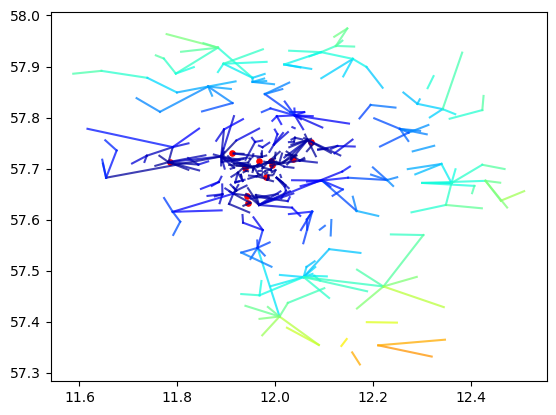

In [10]:
dist_color = plt.cm.jet(np.linspace(0, 1, 500))

cmls_plot = ds_cml
for lon1, lat1, lon2, lat2, dist_to_gauge in zip(
    cmls_plot.site_0_lon,
    cmls_plot.site_0_lat,
    cmls_plot.site_1_lon,
    cmls_plot.site_1_lat,
    dist_cml_gauges.min(dim="station_id").round(1).values * 10,
):
    plt.plot(
        [lon1, lon2], [lat1, lat2], "-", c=dist_color[int(dist_to_gauge)], alpha=0.75
    )

plt.scatter(ds_gauges_ref_1h.lon, ds_gauges_ref_1h.lat, color="red", s=14)

#### Each CML gets the wet-dry time series the radar value averaged along its path

There is a padding of 5 minutes in each direction of time to allow for constant baseline. Addtionally, the nearest rain gauge will bee used to evaluate the CML rianfall estimate in the end.

In [12]:
ds_cml['radar_ref_padded']=ds_radar_along.rainfall_amount.rolling(time=3,center=True).max().interp_like(ds_cml.time)


In [12]:
# resampling original gauge data with a padding to 10s gauge data
ds_gauges_city_org
# this pads the original 1 min data by potentielly up to 15 minutes..
gauges10s = ds_gauges_city_org.interp_like(ds_cml.time)

# filling wet with the wet-dry time series from the nearest rain gauge
ds_cml["rain_nearest_gauge"] = xr.full_like(ds_cml.rsl, fill_value=np.nan)
for cmlid in tqdm(ds_cml.cml_id):
    g_id = dist_cml_gauges.argmin(dim="station_id").sel(cml_id=cmlid)

    tmp_ga_rain = (
        np.repeat(
            gauges10s.isel(station_id=g_id).rainfall_amount.values[:, np.newaxis],
            2,
            axis=1,))

    ds_cml["rain_nearest_gauge"].loc[dict(cml_id=cmlid)] = tmp_ga_rain

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:08<00:00, 44.81it/s]


#### Process one CML to show how results are derived step by step

In [26]:
# select cml id
cml = ds_cml.sel(cml_id=10050)
nearest_gauges=[]
for i in range(4):
    nearest_gauges.append(ds_gauges_ref_1h.isel(
        station_id=dist_cml_gauges.sel(cml_id=10002).argsort()[i]
    ).rainfall_amount)

# process cml with different waa methods
cml["tsl"] = cml.tsl.where((cml.tsl > -10) & (cml.tsl < 40))
cml["rsl"] = cml.rsl.where((cml.rsl > -95) & (cml.rsl < 0))

cml["tl"] = cml.tsl - cml.rsl
cml["tl"] = cml.tl.interpolate_na(dim="time", max_gap="5min", method="linear")

cml["wet"] = cml.radar_ref_padded>0.01

cml["baseline"] = pycml.processing.baseline.baseline_constant(
    trsl=cml.tl,
    wet=cml.wet,
    n_average_last_dry=30,
)

cml["A_obs"] = cml.tl - cml.baseline
cml["A_obs"] = cml.A_obs.where(cml.A_obs >= 0, 0)

cml["waa_leijnse"] = pycml.processing.wet_antenna.waa_leijnse_2008_from_A_obs(
    A_obs=cml.A_obs,
    f_Hz=cml.frequency * 1e6,
    pol=cml.polarization,
    L_km=cml.length / 1000,
)

cml["waa_pastorek"] = pycml.processing.wet_antenna.waa_pastorek_2021_from_A_obs(
    A_obs=cml.A_obs,
    f_Hz=cml.frequency * 1e6,
    pol=cml.polarization,
    L_km=cml.length / 1000,
    A_max=6,
)

cml["waa_schleiss"] = pycml.processing.wet_antenna.waa_schleiss_2013(
    rsl=cml.tl,
    baseline=cml.baseline,
    wet=cml.wet,
    waa_max=2.2,
    delta_t=1,
    tau=15,
)

for waa_method in ["leijnse", "pastorek", "schleiss"]:
    cml[f"A_rain_{waa_method}"] = cml.tl - cml.baseline - cml[f"waa_{waa_method}"]
    cml[f"A_rain_{waa_method}"] = cml[f"A_rain_{waa_method}"].where(
        cml[f"A_rain_{waa_method}"] >= 0, 0
    )
    cml[f"R_{waa_method}"] = pycml.processing.k_R_relation.calc_R_from_A(
        A=cml[f"A_rain_{waa_method}"],
        L_km=cml.length / 1000,
        f_GHz=cml.frequency / 1e3,
        pol=cml.polarization,
    )
cml["R"] = pycml.processing.k_R_relation.calc_R_from_A(
    A=cml.tl - cml.baseline,
    L_km=cml.length / 1000,
    f_GHz=cml.frequency / 1e3,
    pol=cml.polarization,
)

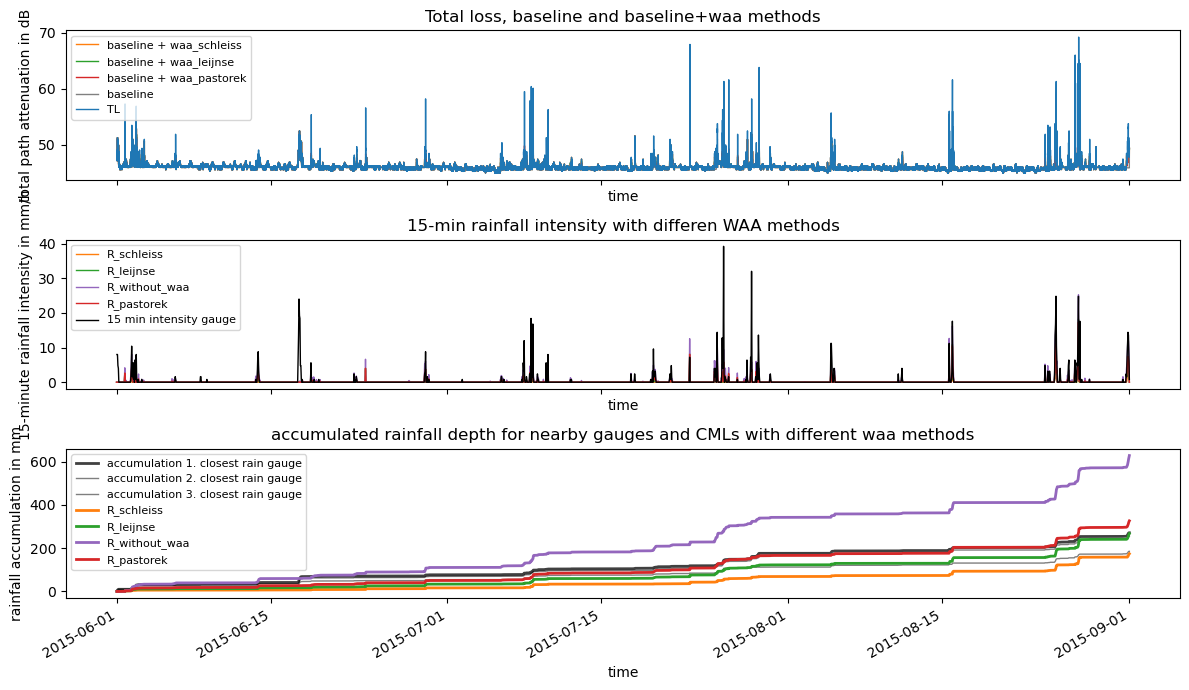

In [27]:
# plot whole CML
fig, ax = plt.subplots(3, 1, figsize=(12, 7), sharex=True)


(cml.baseline + cml.waa_schleiss).isel(sublink_id=0).plot(
    lw=1, label="baseline + waa_schleiss", ax=ax[0], color="C1")
(cml.baseline + cml.waa_leijnse).isel(sublink_id=0).plot(
    lw=1, label="baseline + waa_leijnse", ax=ax[0], color="C2")
(cml.baseline + cml.waa_pastorek).isel(sublink_id=0).plot(
    lw=1,
    label="baseline + waa_pastorek",
    ax=ax[0],
    color="C3",)
(cml.baseline).isel(sublink_id=0).plot(
    lw=1,
    label="baseline ",
    ax=ax[0],
    color="grey",)
cml.tl.isel(sublink_id=0).plot(
    lw=1,
    label="TL",
    ax=ax[0],
    color="C0",)
ax[0].legend(loc = "upper left", fontsize=8)
ax[0].set_title('Total loss, baseline and baseline+waa methods')
ax[0].set_ylabel("total path attenuation in dB")


(cml.R_schleiss.resample(time="60min", label="left").mean()).isel(
    sublink_id=0
).plot(lw=1, label="R_schleiss", ax=ax[1], color="C1")

(cml.R_leijnse.resample(time="60min", label="left").mean()).isel(
    sublink_id=0).plot(lw=1, label="R_leijnse", ax=ax[1], color="C2")

(cml.R.resample(time="60min", label="left").mean()).isel(sublink_id=0).plot(
    lw=1, label="R_without_waa", ax=ax[1], color="C4")

(cml.R_pastorek.resample(time="60min", label="left").mean()).isel(
    sublink_id=0
).plot(
    lw=1,
    label="R_pastorek",
    ax=ax[1],
    color="C3",)
(nearest_gauges[0]*4).plot(lw=1, label="15 min intensity gauge", ax=ax[1],color='black')
ax[1].legend(loc = "upper left", fontsize=8)
ax[1].set_title('15-min rainfall intensity with differen WAA methods')
ax[1].set_ylabel("15-minute rainfall intensity in mm/h")


nearest_gauges[i].cumsum().plot(lw=2, label="accumulation 1. closest rain gauge", ax=ax[2],color='black',alpha=0.75)
for i in [1,2]:
    (nearest_gauges[i].cumsum()).plot(lw=1, label="accumulation "+str(i+1)+". closest rain gauge", ax=ax[2],color='black',alpha=0.5)
    
(cml.R_schleiss.isel(sublink_id=0) / 360).cumsum().plot(
    lw=2, label="R_schleiss", ax=ax[2], color="C1")

(cml.R_leijnse.isel(sublink_id=0) / 360).cumsum().plot(
    lw=2, label="R_leijnse", ax=ax[2], color="C2")

(cml.R.isel(sublink_id=0) / 360).cumsum().plot(
    lw=2, label="R_without_waa", ax=ax[2], color="C4")

(cml.R_pastorek.isel(sublink_id=0) / 360).cumsum().plot(
    lw=2,
    label="R_pastorek",
    ax=ax[2],
    color="C3",)


ax[2].legend(loc = "upper left", fontsize=8)
ax[2].set_title('accumulated rainfall depth for nearby gauges and CMLs with different waa methods')
ax[2].set_ylabel("rainfall accumulation in mm")

plt.tight_layout();

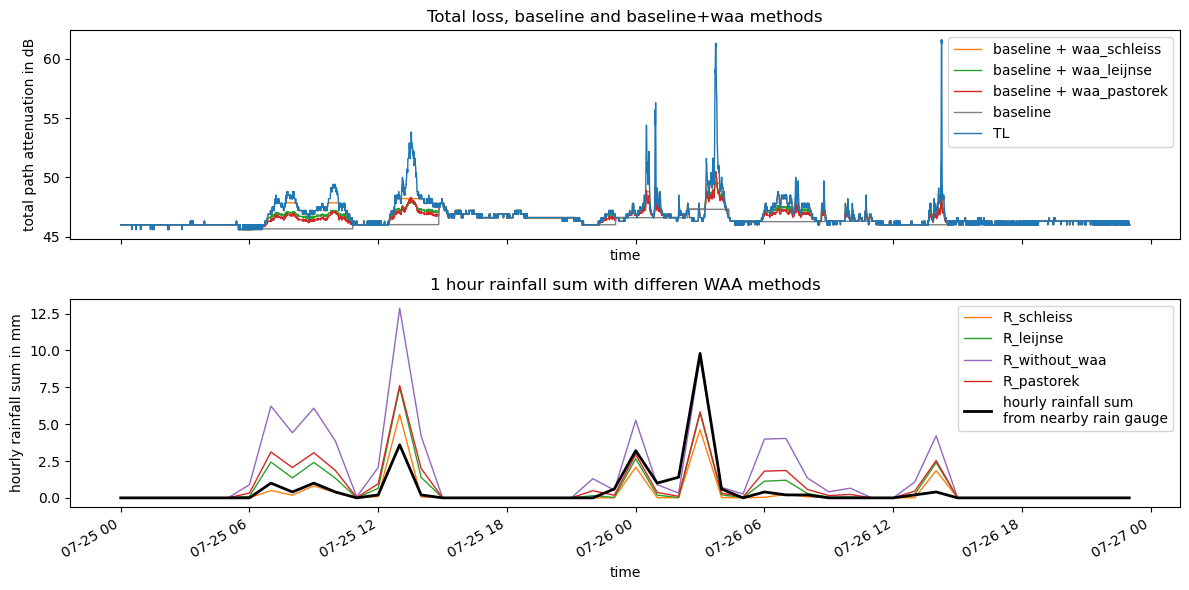

In [29]:
# plot one zoomed in event
tstart="2015-07-25 00:00"
tend="2015-07-26 23:00"
cml_sel = cml.sel(time=slice(tstart,tend))
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

(cml_sel.baseline + cml_sel.waa_schleiss).isel(sublink_id=0).plot(
    lw=1, label="baseline + waa_schleiss", ax=ax[0], color="C1")
(cml_sel.baseline + cml_sel.waa_leijnse).isel(sublink_id=0).plot(
    lw=1, label="baseline + waa_leijnse", ax=ax[0], color="C2")
(cml_sel.baseline + cml_sel.waa_pastorek).isel(sublink_id=0).plot(
    lw=1,label="baseline + waa_pastorek",ax=ax[0], color="C3",)
                  
(cml_sel.baseline).isel(sublink_id=0).plot(lw=1, label="baseline ", ax=ax[0], color="grey",)
cml_sel.tl.isel(sublink_id=0).plot(lw=1, label="TL", ax=ax[0], color="C0",)
ax[0].legend()
ax[0].set_title('Total loss, baseline and baseline+waa methods')
ax[0].set_ylabel("total path attenuation in dB")


(cml_sel.R_schleiss.resample(time="60min").mean()).isel(
    sublink_id=0).plot(lw=1, label="R_schleiss", ax=ax[1], color="C1")

(cml_sel.R_leijnse.resample(time="60min").mean()).isel(
    sublink_id=0).plot(lw=1, label="R_leijnse", ax=ax[1], color="C2")

(cml_sel.R.resample(time="60min").mean()).isel(sublink_id=0).plot(
    lw=1, label="R_without_waa", ax=ax[1], color="C4")

(cml_sel.R_pastorek.resample(time="60min").mean()).isel(
    sublink_id=0).plot(lw=1, label="R_pastorek", ax=ax[1], color="C3",)
                  
(nearest_gauges[0].sel(time=slice(tstart,tend))).plot(lw=2, label="hourly rainfall sum\nfrom nearby rain gauge", ax=ax[1],color='black')
ax[1].legend()
ax[1].set_title('1 hour rainfall sum with differen WAA methods')
ax[1].set_ylabel("hourly rainfall sum in mm")

plt.tight_layout();

#### Proccess all data
This will need a lot of RAM (~70GB). Use HPC, a shorter period, less CMLs or dask to parallize this.

In [30]:
%%time
ds_cml["tsl"] = ds_cml.tsl.where((ds_cml.tsl > -10) & (ds_cml.tsl < 40))
ds_cml["rsl"] = ds_cml.rsl.where((ds_cml.rsl > -95) & (ds_cml.rsl < 0))

ds_cml["tl"] = ds_cml.tsl - ds_cml.rsl
ds_cml["tl"] = ds_cml.tl.interpolate_na(dim="time", max_gap="5min", method="linear")

# this equals to a threshold of at least 0.12 mm/h radar intensity
ds_cml["wet"] = ds_cml.radar_ref_padded>0.01

ds_cml["baseline"] = pycml.processing.baseline.baseline_constant(
    trsl=ds_cml.tl,
    wet=ds_cml.wet,
    n_average_last_dry=30,
)

ds_cml["A_obs"] = ds_cml.tl - ds_cml.baseline
ds_cml["A_obs"] = ds_cml.A_obs.where(ds_cml.A_obs >= 0, 0)

ds_cml["waa_leijnse"] = pycml.processing.wet_antenna.waa_leijnse_2008_from_A_obs(
    A_obs=ds_cml.A_obs,
    f_Hz=ds_cml.frequency * 1e6,
    pol=ds_cml.polarization,
    L_km=ds_cml.length / 1000,
)

ds_cml["waa_pastorek"] = pycml.processing.wet_antenna.waa_pastorek_2021_from_A_obs(
    A_obs=ds_cml.A_obs,
    f_Hz=ds_cml.frequency * 1e6,
    pol=ds_cml.polarization,
    L_km=ds_cml.length / 1000,
    A_max=6,
)

ds_cml["waa_schleiss"] = pycml.processing.wet_antenna.waa_schleiss_2013(
    rsl=ds_cml.tl,
    baseline=ds_cml.baseline,
    wet=ds_cml.wet,
    waa_max=2.2,
    delta_t=1,
    tau=15,
)

for waa_method in ["leijnse", "pastorek", "schleiss"]:
    ds_cml[f"A_rain_{waa_method}"] = (
        ds_cml.tl - ds_cml.baseline - ds_cml[f"waa_{waa_method}"]
    )
    ds_cml[f"A_rain_{waa_method}"] = ds_cml[f"A_rain_{waa_method}"].where(
        ds_cml[f"A_rain_{waa_method}"] >= 0, 0
    )
    ds_cml[f"R_{waa_method}"] = pycml.processing.k_R_relation.calc_R_from_A(
        A=ds_cml[f"A_rain_{waa_method}"],
        L_km=ds_cml.length / 1000,
        f_GHz=ds_cml.frequency / 1e3,
        pol=ds_cml.polarization,
    )
ds_cml["R"] = pycml.processing.k_R_relation.calc_R_from_A(
    A=ds_cml.tl - ds_cml.baseline,
    L_km=ds_cml.length / 1000,
    f_GHz=ds_cml.frequency / 1e3,
    pol=ds_cml.polarization,
)

CPU times: user 2min 11s, sys: 13.3 s, total: 2min 24s
Wall time: 2min 25s


In [31]:
# calculate bias per CML
bias_all_list, bias_close_list = [], []
for rr in ["R", "R_schleiss", "R_leijnse", "R_pastorek"]:
    cmls_1h_sum = (ds_cml[rr].isel(sublink_id=0) / 360).resample(time="60min").sum()
    tmp_list_all, tmp_list_close = [], []
    for cmlid in tqdm(ds_cml.cml_id):
        tmp_cml = cmls_1h_sum.sel(cml_id=cmlid)
        gauge = ds_gauges_ref_1h.isel(
            station_id=dist_cml_gauges.sel(cml_id=cmlid).argmin()
        ).rainfall_amount

        if tmp_cml.mean() > 0:
            bias = (((gauge.mean() - tmp_cml.mean()) / gauge.mean()) * 100).values
            tmp_list_all.append(bias)
            if (
                dist_cml_gauges.sel(cml_id=cmlid).min() < 3
            ):  # define distance in km for which close CMLs should be analysed
                tmp_list_close.append(bias)

    bias_all_list.append(tmp_list_all)
    bias_close_list.append(tmp_list_close)

bias_all_arr = np.array(bias_all_list)
bias_close_arr = np.array(bias_close_list)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:01<00:00, 225.26it/s]


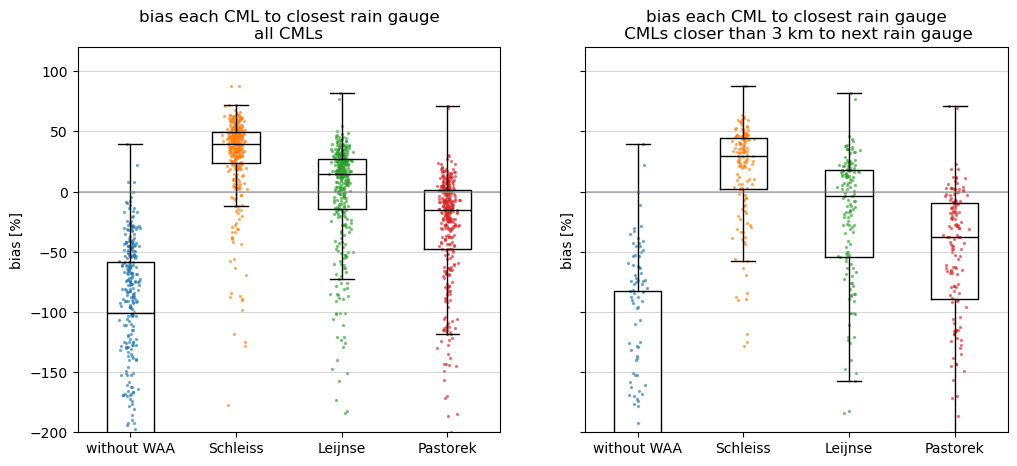

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for i in range(4):
    x = np.random.normal(i + 1, 0.04, size=len(bias_all_arr[i]))
    ax[0].scatter(x, bias_all_arr[i], s=2, alpha=0.5)
ax[0].boxplot(bias_all_arr.T, sym="", medianprops=dict(color="black"))
ax[0].set_ylim(-200, 120)
ax[0].hlines(0, 0.5, 4.5, color="grey", alpha=0.5)
ax[0].set_xticklabels(["without WAA", "Schleiss", "Leijnse", "Pastorek"])
ax[0].set_ylabel("bias [%]")
ax[0].set_title("bias each CML to closest rain gauge\nall CMLs")
ax[0].grid(axis="y", alpha=0.5)

for i in range(4):
    x = np.random.normal(i + 1, 0.04, size=len(bias_close_arr[i]))
    ax[1].scatter(x, bias_close_arr[i], s=2, alpha=0.5)
ax[1].boxplot(bias_close_arr.T, sym="", medianprops=dict(color="black"))
ax[1].set_ylim(-200, 120)
ax[1].hlines(0, 0.5, 4.5, color="grey", alpha=0.5)
ax[1].set_xticklabels(["without WAA", "Schleiss", "Leijnse", "Pastorek"])
ax[1].set_ylabel("bias [%]")
ax[1].set_title(
    "bias each CML to closest rain gauge\n CMLs closer than 3 km to next rain gauge"
)
ax[1].grid(axis="y", alpha=0.5);